# HomeWork 11

**DeadLine : 23:59 20 Azar 1399**

**Total points : 100pts**


Import some prerequisites:

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Run this cell for plotting.

In [7]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

# PART 3

**Point : 30 pts**

Here is for your helper functions(optional).

In [22]:
def compute_k(image, element):
    thres = image.copy()
    k = 1
    while cv2.erode(image, element, iterations = k).any():
        k += 1
    return k

Implement this function to get the input image and return the skeleton of the input image.

In [43]:
def get_skeleton(image):
    """
    Finds the skeleton of the input image.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        numpy.ndarray: The skeleton image.  
    """
    
    print(image.shape)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image[i, j] = 255;
    
#     im = cv2.rectangle(image,(0,0),(566,1182),(255,255,255), -1)
    
    im = cv2.rectangle(image,(140,100),(1000, 500),(0,0,0),-1)
    
    blur = cv2.GaussianBlur(im, (3, 3) ,0)
    ret, binary = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY_INV)

    element = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype = np.uint8)
    
    K = compute_k(binary, element)    
    union = np.zeros_like(binary)
    
    for i in range(K):
        
        erosion = cv2.erode(binary, element, iterations = i)
        opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, element)
        partial_result = cv2.subtract(erosion, opening)
        union = cv2.add(union, partial_result)

    return union

Test your implementation (don't change this cell).

(567, 1183)


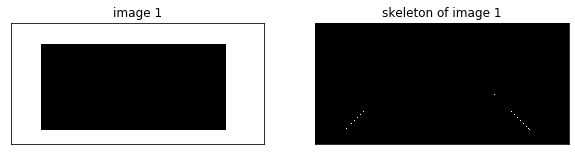

In [44]:
image_list = []

image1 = cv2.imread(os.path.join('images', 'q3a.png'), cv2.IMREAD_GRAYSCALE)
image_list.append([image1, 'image 1', 'img'])
image_list.append([get_skeleton(image1), 'skeleton of image 1','img'])

# image2 = cv2.imread(os.path.join('images', 'q3b.jpg'), cv2.IMREAD_GRAYSCALE)
# image_list.append([image2, 'image 2', 'img'])
# image_list.append([get_skeleton(image2), 'skeleton of image 2','img'])

# image3 = cv2.imread(os.path.join('images', 'q3c.png'), cv2.IMREAD_GRAYSCALE)
# image_list.append([image3, 'image 3', 'img'])
# image_list.append([get_skeleton(image3), 'skeleton of image 3', 'img'])

plotter(image_list, 3, 2, True, 10, 10, 'Q3')

# PART 4

**Point : 30 pts**

Here is for your helper functions(optional).

In [6]:
import numpy.ma as ma

def make_slice(image, offset, i, j):
    return image[i - offset : i + offset + 1, j - offset : j + offset + 1]

def get_indices(shape, offset):
    indices = []
    for val in range(shape):
        if val - offset >= 0 and val + offset + 1 <= shape:
            indices.append(val)
    return indices

def crop_padding(image, offset):
    return image[offset : image.shape[0] - offset, offset : image.shape[1] - offset].astype(np.uint8)

def gray_morphology(image, element, method):
    
    offset = element.shape[0] // 2
    
    rows = get_indices(image.shape[0], offset)
    cols = get_indices(image.shape[1], offset)
    
    result_image = np.zeros(image.shape[:2])
    
    for i in rows:
        for j in cols:

            image_slice = ma.masked_array(make_slice(image, offset, i, j), mask = np.logical_not(element))
            
            if method == 'ERODE':
                result_image[i, j] = image_slice.min()
            elif method == 'DILATE':
                result_image[i, j] = image_slice.max()
                
    return result_image

Please, set your structuring element here:

In [7]:
structuring_element = np.ones((3, 3))

Implement these functions for calculating dilation and erosion in RGB space.

In [8]:
def RGB_dilate(image, structuring_element):
    '''
    Applies dilation in RGB space.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        dilated_image (numpy.ndarray): The dilated result image.   
    '''
    offset = structuring_element.shape[0] // 2
    
    padded = cv2.copyMakeBorder(image, offset, offset, offset, offset, cv2.BORDER_REFLECT)
    
    channels = cv2.split(padded)

    result = []
    for ch in channels:
        result.append(gray_morphology(ch, structuring_element, 'DILATE'))
    
    dilated_image = crop_padding(cv2.merge(tuple(result)), offset)
    return dilated_image

In [9]:
def RGB_erode(image, structuring_element):
    '''
    Applies erosion in RGB space.
    
    Parameters:
        image (numpy.ndarray): The input image.
        structuring_element (numpy.ndarray): The structuring element must be square.
    
    Returns:
        eroded_image (numpy.ndarray): The eroded result image.   
    '''
    offset = structuring_element.shape[0] // 2
    
    padded = cv2.copyMakeBorder(image, offset, offset, offset, offset, cv2.BORDER_REFLECT)
    
    channels = cv2.split(padded)

    result = []
    for ch in channels:
        result.append(gray_morphology(ch, structuring_element, 'ERODE'))
    
    eroded_image = crop_padding(cv2.merge(tuple(result)), offset)
    return eroded_image

Test your implementation (don't change this cell).

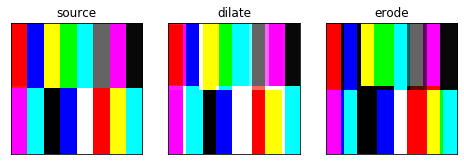

In [10]:
image_list = []
image = cv2.imread(os.path.join('images', 'q4.jpg'), cv2.IMREAD_COLOR)
image_list.append([image, 'source', 'img'])
image_list.append([RGB_dilate(image, structuring_element), 'dilate', 'img'])
image_list.append([RGB_erode(image, structuring_element), 'erode', 'img'])
plotter(image_list, 1, 3, True, 8, 6, 'Q4')

To create proper files for sending in the Quera run this cell, please.

In [11]:
!python notebook_converter.py

End!!!